In [1]:
import pyspark
from pyspark.sql.functions import abs as abs_col
from pyspark.sql.functions import *

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

spark = (
    SparkSession.builder
    .appName("Big Data Analytics")
    .master("yarn")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 23:03:12 INFO SparkEnv: Registering MapOutputTracker
23/11/16 23:03:12 INFO SparkEnv: Registering BlockManagerMaster
23/11/16 23:03:12 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/16 23:03:12 INFO SparkEnv: Registering OutputCommitCoordinator


In [2]:
df = spark.read.csv('gs://fifa_players/data_engineering_pytorch.csv', header = True, inferSchema = True)

In [3]:
df.show(5, vertical = True)

23/11/16 23:03:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-----------------------------------------
 overall                     | 90                 
 potential                   | 90                 
 age                         | 28                 
 height_cm                   | 193                
 weight_kg                   | 92                 
 league_level                | 1                  
 preferred_foot              | Right              
 weak_foot                   | 4                  
 skill_moves                 | 1                  
 international_reputation    | 5                  
 work_rate                   | Medium/Medium      
 body_type                   | Normal (185+)      
 pace                        | 68                 
 passing                     | 56                 
 defending                   | 50                 
 physic                      | 64                 
 attacking_crossing          | 25                 
 attacking_finishing         | 25                 
 attacking_heading_accuracy  | 

In [4]:
df_read = df

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
string_cols = ['preferred_foot','work_rate', 'body_type']
for col in string_cols:
    print(df_read.select(col).distinct().show())

indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in string_cols]
encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_vec") for column in string_cols]

pipeline = Pipeline(stages=indexers + encoders)

df_transformed = pipeline.fit(df_read).transform(df_read)

+--------------+
|preferred_foot|
+--------------+
|          Left|
|         Right|
+--------------+

None
+-------------+
|    work_rate|
+-------------+
|Medium/Medium|
|  High/Medium|
|     Low/High|
|      Low/Low|
|    High/High|
|   Medium/Low|
|     High/Low|
|  Medium/High|
|   Low/Medium|
+-------------+

None
+----------------+
|       body_type|
+----------------+
|   Stocky (170-)|
|   Normal (185+)|
|     Lean (185+)|
|Normal (170-185)|
|     Lean (170-)|
|  Lean (170-185)|
|   Normal (170-)|
|   Stocky (185+)|
|Stocky (170-185)|
|          Unique|
+----------------+

None


In [6]:
# Vector Assmebling steps
from pyspark.ml.feature import VectorAssembler

feature_cols = df_transformed.drop('preferred_foot', 'overall', 'work_rate', 'body_type', 'preferred_foot_index', 'work_rate_index', 'body_type_index', 'UID').columns
print(feature_cols)

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_assembled = vector_assembler.transform(df_transformed)

['potential', 'age', 'height_cm', 'weight_kg', 'league_level', 'weak_foot', 'skill_moves', 'international_reputation', 'pace', 'passing', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'log_value_eur', 'log_wage_eur', 'preferred_foot_vec', 'work_rate_vec', 'body_type_vec']


In [7]:
from pyspark.sql.types import DoubleType, ArrayType
from pyspark.sql.functions import udf
import pandas as pd
train, test = df_assembled.randomSplit([0.7, 0.3], seed=504)

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))
train_pd = train.withColumn("features", to_array("features")).toPandas()
test_pd = test.withColumn("features", to_array("features")).toPandas()

In [9]:
# !pip3 install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np

x_train = torch.from_numpy(np.array(train_pd['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(train_pd['overall'].values.tolist(), np.int64))

x_test = torch.from_numpy(np.array(test_pd['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(test_pd['overall'].values.tolist(), np.int64))

In [10]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

In [13]:
class myNeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.ln1 = nn.Linear(input_size, 64)
        self.ln2 = nn.Linear(64, 32)
        self.ln3 = nn.Linear(32, 1)
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = self.ln3(x)
        return x


In [14]:
input_size = x_train.shape[1]
model = myNeuralNet(input_size)

batch_size = 128
num_epochs = 150
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr)
loss_fcn = nn.MSELoss()

loss_per_batch = []
train_loss = []
test_loss = []
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    model = model.train()

    # Compute the train/validate/accuracy for each epoch and save the best model so far every epoch
    total_train_loss = 0
    total_test_loss = 0
    for batch_id, (x,y) in enumerate(train_loader):
        opt.zero_grad()
        output = model(x)
        output = output.squeeze().float()
        loss = loss_fcn(output, y.float())

        total_train_loss += loss.item()
        loss_per_batch.append(loss.item())
        loss.backward()
        opt.step()
    train_loss.append(total_train_loss / len(train_loader))
    
    # Compute the validation loss
    model = model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    with torch.no_grad():
        for batch_id, (x,y) in enumerate(test_loader):
            output = model(x)
            output = model(x)
            output = output.squeeze().float()
            loss = loss_fcn(output, y.float())
            total_test_loss += loss.item()
    test_loss.append(total_test_loss / len(test_loader))

    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch} train loss: {train_loss[-1]}")
        print(f"Epoch {epoch} test loss: {test_loss[-1]}")
    # Save the best model so far
    
    if epoch == 0:
        best_model = model
        best_epoch = epoch
    elif test_loss[-1] <  __builtins__.min(test_loss[:-1]):
        best_model = model
        best_epoch = epoch
        

    # Early stopping
    if epoch - best_epoch >= 50:
        print("Early stopping at epoch {}".format(epoch))
        break



Epoch 4 train loss: 10.33547678241482
Epoch 4 test loss: 9.020422646493623
Epoch 9 train loss: 3.3927003160699623
Epoch 9 test loss: 3.08506567550428
Epoch 14 train loss: 2.3926691451630036
Epoch 14 test loss: 2.225987206805836
Epoch 19 train loss: 2.0083742358467798
Epoch 19 test loss: 1.9097396026958118
Epoch 24 train loss: 1.6933922055479769
Epoch 24 test loss: 1.6909085150920984
Epoch 29 train loss: 1.5720871795307507
Epoch 29 test loss: 1.4924682198148784
Epoch 34 train loss: 1.412939865867813
Epoch 34 test loss: 1.3992323261318784
Epoch 39 train loss: 1.3213106022252665
Epoch 39 test loss: 1.2752542513789553
Epoch 44 train loss: 1.257711429100532
Epoch 44 test loss: 1.2320120605555447
Epoch 49 train loss: 1.2012769843076732
Epoch 49 test loss: 1.610440604614489
Epoch 54 train loss: 1.10393983048278
Epoch 54 test loss: 1.117017565351544
Epoch 59 train loss: 1.1476325926842628
Epoch 59 test loss: 1.104585886001587
Epoch 64 train loss: 1.1127219114984785
Epoch 64 test loss: 1.084297

In [15]:

print('Best epoch: {}'.format(best_epoch))
print('Train loss: {}'.format(train_loss[best_epoch]))
print('Test loss: {}'.format(test_loss[best_epoch]))
print('batch size: {}'.format(batch_size))
print('learning rate: {}'.format(lr))
print('number of epochs: {}'.format(num_epochs))

# Best model
best_model = best_model.eval()
print(best_model)

Best epoch: 142
Train loss: 0.8157163823579813
Test loss: 0.7887245100555997
batch size: 128
learning rate: 0.001
number of epochs: 150
myNeuralNet(
  (ln1): Linear(in_features=59, out_features=64, bias=True)
  (ln2): Linear(in_features=64, out_features=32, bias=True)
  (ln3): Linear(in_features=32, out_features=1, bias=True)
)


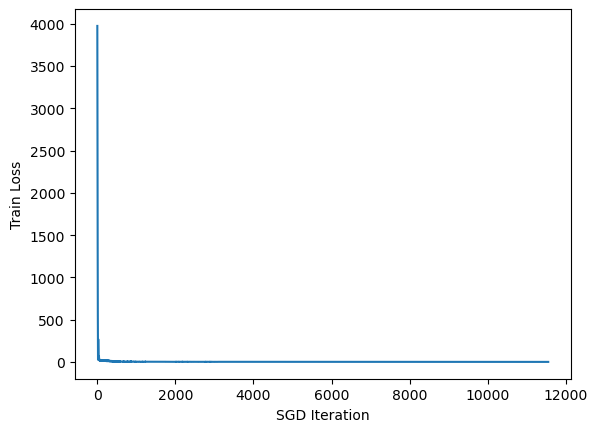

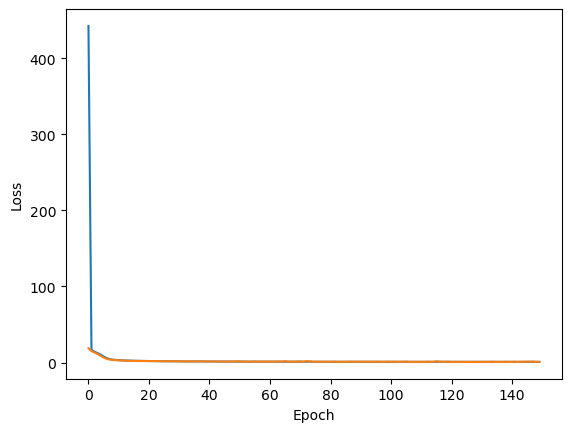

In [16]:
# Train loss per SGD Iteration
import matplotlib.pyplot as plt
plt.plot(range(1, len(loss_per_batch) + 1), loss_per_batch, label='Train Loss per Batch')
plt.ylabel('Train Loss')
plt.xlabel('SGD Iteration')
plt.show()

plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [42]:
class myDeepNeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.ln1 = nn.Linear(input_size, 128)
        self.ln2 = nn.Linear(128, 64)
        self.ln3 = nn.Linear(64, 32)
        self.ln4 = nn.Linear(32, 16)
        self.ln5 = nn.Linear(16, 8)
        self.ln6 = nn.Linear(8, 4)
        self.ln7 = nn.Linear(4, 1)
    
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.relu(self.ln3(x))
        x = F.relu(self.ln4(x))
        x = F.relu(self.ln5(x))
        x = F.relu(self.ln6(x))
        x = self.ln7(x)
        return x

In [44]:
input_size = x_train.shape[1]
model = myNeuralNet(input_size)

batch_size = 128
num_epochs = 150
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr)
loss_fcn = nn.MSELoss()

loss_per_batch = []
train_loss = []
test_loss = []
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    model = model.train()

    # Compute the train/validate/accuracy for each epoch and save the best model so far every epoch
    total_train_loss = 0
    total_test_loss = 0
    for batch_id, (x,y) in enumerate(train_loader):
        opt.zero_grad()
        output = model(x)
        output = output.squeeze().float()
        loss = loss_fcn(output, y.float())

        total_train_loss += loss.item()
        loss_per_batch.append(loss.item())
        loss.backward()
        opt.step()
    train_loss.append(total_train_loss / len(train_loader))
    
    # Compute the validation loss
    model = model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    with torch.no_grad():
        for batch_id, (x,y) in enumerate(test_loader):
            output = model(x)
            output = model(x)
            output = output.squeeze().float()
            loss = loss_fcn(output, y.float())
            total_test_loss += loss.item()
    test_loss.append(total_test_loss / len(test_loader))

    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch} train loss: {train_loss[-1]}")
        print(f"Epoch {epoch} test loss: {test_loss[-1]}")
    # Save the best model so far
    
    if epoch == 0:
        best_model = model
        best_epoch = epoch
    elif test_loss[-1] <  __builtins__.min(test_loss[:-1]):
        best_model = model
        best_epoch = epoch
        

    # Early stopping
    if epoch - best_epoch >= 50:
        print("Early stopping at epoch {}".format(epoch))
        break

Epoch 4 train loss: 10.561785487385539
Epoch 4 test loss: 9.989825624408144
Epoch 9 train loss: 4.711332327359683
Epoch 9 test loss: 4.4307552973429365
Epoch 14 train loss: 3.0819323202232263
Epoch 14 test loss: 3.2618283575231377
Epoch 19 train loss: 2.3503159439408936
Epoch 19 test loss: 2.2573561812892105
Epoch 24 train loss: 1.953396386914439
Epoch 24 test loss: 1.8055762775016553
Epoch 29 train loss: 1.6636402870153453
Epoch 29 test loss: 1.7824291388193767
Epoch 34 train loss: 1.5518573692866735
Epoch 34 test loss: 1.4644437630971272
Epoch 39 train loss: 1.4067205755741565
Epoch 39 test loss: 1.4061652530323376
Epoch 44 train loss: 1.3098234936788484
Epoch 44 test loss: 1.2616342522881248
Epoch 49 train loss: 1.2537650798822377
Epoch 49 test loss: 1.7036453196496675
Epoch 54 train loss: 1.1805720035131875
Epoch 54 test loss: 1.165072545860753
Epoch 59 train loss: 1.220938547865137
Epoch 59 test loss: 1.1291194449771533
Epoch 64 train loss: 1.0907608409980676
Epoch 64 test loss: 1

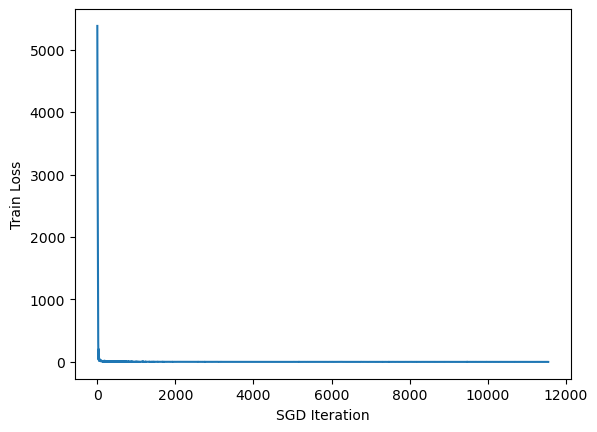

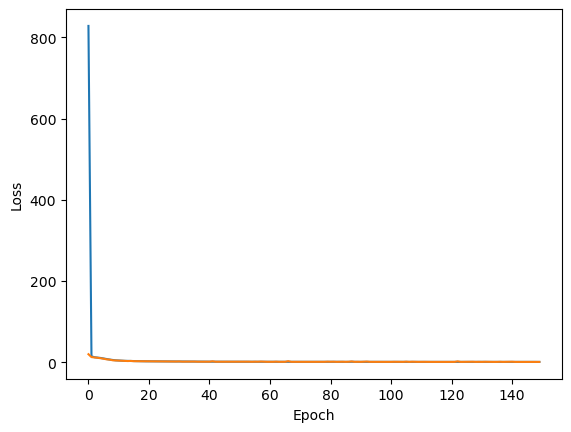

In [45]:
# Train loss per SGD Iteration
import matplotlib.pyplot as plt
plt.plot(range(1, len(loss_per_batch) + 1), loss_per_batch, label='Train Loss per Batch')
plt.ylabel('Train Loss')
plt.xlabel('SGD Iteration')
plt.show()

plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [46]:
print('Best epoch: {}'.format(best_epoch))
print('Train loss: {}'.format(train_loss[best_epoch]))
print('Test loss: {}'.format(test_loss[best_epoch]))
print('batch size: {}'.format(batch_size))
print('learning rate: {}'.format(lr))
print('number of epochs: {}'.format(num_epochs))

# Best model
best_model = best_model.eval()
print(best_model)

Best epoch: 148
Train loss: 0.8267784761143969
Test loss: 0.8214127439441103
batch size: 128
learning rate: 0.001
number of epochs: 150
myNeuralNet(
  (ln1): Linear(in_features=59, out_features=64, bias=True)
  (ln2): Linear(in_features=64, out_features=32, bias=True)
  (ln3): Linear(in_features=32, out_features=1, bias=True)
)
